## Load Raw Dataset
**Before any data analysis, we need to import the necessary libraries and load the raw dataset.**

<small> First, we import essential Python libraries for data manipulation, visualization, and statistical analysis, including `pandas`, `matplotlib`, `seaborn`, `numpy`, `plotly`, and `scipy`.
Next, we define the file paths for the NYC 311 complaints dataset and the population data by ZIP code. The code checks if these files exist before attempting to load them into DataFrames. If a file is missing, it prints a warning message; otherwise, it loads the data and confirms the number of rows imported. This ensures our analysis starts with verified and accessible datasets.
</small>

In [81]:
#Import Packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from scipy.stats import poisson



complaints_path = "data/raw/nyc_311_raw.csv"
pop_path = "data/raw/nyc_zcta_population.csv"

#Checks and Loads the previously saved raw dataset to start analyzing.
# Load complaints dataset
if not os.path.exists(complaints_path):
    print(f"File not found: {complaints_path}")
else:
    complaints_df = pd.read_csv(complaints_path)
    print(f"Loaded complaints data: {complaints_df.shape} rows")

# Load population dataset
if not os.path.exists(pop_path):
    print(f"File not found: {pop_path}")
else:
    pop_df = pd.read_csv(pop_path)
    print(f"Loaded population data: {pop_df.shape} rows")

Loaded complaints data: (1000, 48) rows
Loaded population data: (178, 5) rows


In [82]:
print(pop_df.columns)
print(complaints_df.columns)

Index(['modzcta', 'label', 'zcta', 'pop_est', 'the_geom'], dtype='object')
Index(['__id', 'unique_key', 'created_date', 'closed_date', 'agency',
       'agency_name', 'complaint_type', 'descriptor', 'location_type',
       'incident_zip', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'intersection_street_1', 'intersection_street_2',
       'address_type', 'city', 'landmark', 'facility_type', 'status',
       'due_date', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'vehicle_type',
       'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
       'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment',
       'latitude', 'longitude', 'location_address', 'location_city',
       'location_state', 'location_zip', 'location.type',
       'lo

## Cleaning Area code data

<small>
In this segment, I created a function to clean and standardize New York City zip codes from both the <code>complaints_df</code> and <code>pop_df</code> DataFrames. This step is essential because zip codes can be misrepresented depending on how the data is stored. For example, many NYC zip codes begin with a leading zero (e.g., <code>02138</code>), but when stored as integers in a DataFrame, the leading zero is dropped, changing the zip code to <code>2138</code>. This creates inconsistencies that can interfere with any location-based analysis, as it becomes difficult to correctly identify or match geographic areas.

To avoid such issues—especially when it's unclear whether the original data was stored as strings or numbers—it's best practice to convert zip code columns to string type and ensure they all have exactly five digits. If necessary, leading zeros are added to achieve this format.

Interestingly, even though both of the DataFrames contain NYC zip codes, the column names differ: <code>incident_zip</code> in <code>complaints_df</code> and <code>MODZCTA</code> in <code>pop_df</code>. Because of this, I had to clean and standardize each DataFrame individually. After cleaning, I renamed both columns to <code>zip_code</code> so that future merges between the datasets would be straightforward and based on a shared, consistent column name.

The function I wrote, <code>clean_zip()</code>, handles several tasks in one go: it fills in missing values with an empty string, converts the series to string type, removes any decimal points (which can appear if zip codes were mistakenly stored as floats), and pads each value with leading zeros to ensure it meets the five-digit standard.
<small>

In [83]:
# Function to clean zip code strings
def clean_zip(zip_series):
    return (
        zip_series
        .fillna("")                           # Replace NaN with empty string
        .astype(str)                         # Convert to string
        .str.split('.', expand=True)[0]     # Remove decimal part (if any), keep only before '.'
        .str.zfill(5)                       # Pad with leading zeros
    )

# Clean complaints ZIP codes
complaints_df["incident_zip"] = clean_zip(complaints_df["incident_zip"])

# Clean population ZIP codes
pop_df["modzcta"] = clean_zip(pop_df["modzcta"])

# Rename columns for consistency before merging
pop_df.rename(columns={"modzcta": "zip_code"}, inplace=True)
complaints_df.rename(columns={"incident_zip": "zip_code"}, inplace=True)

print(complaints_df['created_date'].min())
print(complaints_df['created_date'].max())




2010-08-09T15:20:02.000
2024-06-11T21:02:25.000


**Now we want to:**

<small>
<li>Compare ZIP codes from two datasets (<code>complaints_df</code> and <code>pop_df</code>)
<li>Filter out missing or unexpected ZIP codes
<li>Check for overlap between the two sets of ZIP codes <br>

To do this, we start by creating two variables: <code>complaint_zips</code> and <code>pop_zips</code>. Each holds the unique ZIP codes from its respective dataset. We extract the unique ZIP codes, convert them to Python sets (which are unordered and optimized for set operations like difference and intersection), and store them for comparison. 

Next, we create a variable called <code>missing_zips</code>, which contains ZIP codes that appear in the complaints dataset but are not found in the population dataset. This step is important because mismatched ZIP codes can cause problems during merging. If a ZIP code exists in <code>complaints_df</code> but not in <code>pop_df</code>, the merge will result in <code>NaN</code> values in the corresponding population columns. These missing values could negatively affect downstream analysis — especially when performing calculations or aggregations by ZIP code. Identifying these mismatches in advance helps ensure a cleaner and more reliable dataset.
<small>

In [84]:
# Identify ZIP codes that appear in the complaints dataset but are missing from the population dataset.
# This helps detect mismatches or data gaps before merging, which could affect per-capita calculations.
complaint_zips = set(complaints_df["zip_code"].unique())
pop_zips = set(pop_df["zip_code"].unique())

missing_zips = complaint_zips - pop_zips
print(f"Number of zip codes in complaints not found in population data: {len(missing_zips)}")
print(f"The missing zips: {list(missing_zips)}")


Number of zip codes in complaints not found in population data: 4
The missing zips: ['11001', '11249', '00000', '10020']


## Merging our datasets into a new DataFrame

<small> In this segment, we create a new merged DataFrame called `merged_df` by combining our two previous datasets, `pop_df` and `complaints_df`. We then confirm that the merge was successful by verifying the total number of columns in the new DataFrame compared to the original ones.

<li><code>pop_df</code> had 5 columns and <code>complaints_df</code> had 48 columns. Since they share one common column (<code>zip_code</code>), the resulting merged DataFrame should have 53 columns minus 1 (for the shared column), resulting in 52 columns.

</small>



In [85]:
# Merge complaints with population data on zip code
merged_df = complaints_df.merge(pop_df, on="zip_code", how="left")

#Checks to make sure the number of columns from complaints_df and pop_df sums to the total collective amount of columns in the new merged_df data frame.
print(pop_df.shape[1]) #----> Exspected 5
print(complaints_df.shape[1]) #----> Expected 48
#Since they both share one column, "zip_code" remove one count from either expectation (doesn't matter which one) and sum the remainder.

num = merged_df.shape[1]
print(num) #----> Expected 52

print(merged_df["pop_est"])


5
48
52
0      23140.0
1      47798.0
2      47798.0
3      86421.0
4      34118.0
        ...   
995    31780.0
996    44994.0
997     3454.0
998    34118.0
999    20801.0
Name: pop_est, Length: 1000, dtype: float64


<small>
Here, we perform a quick analysis to identify and count missing values in each column of the 'merged_df' DataFrame.

How does this work?

<li> We use the <code>.isnull()</code> method on <code>merged_df</code>, which returns a DataFrame of Boolean values (<code>True</code> for missing values like <code>NaN</code> or <code>None</code>, and <code>False</code> otherwise).
<li>Since <code>True</code> is treated as <code>1</code> and <code>False</code> as <code>0</code> in Python, applying <code>.sum()</code> sums the total count of missing values per column.
<li>This results in a Series where the index represents the column names and the values represent the number of missing entries in each column.
<li>Finally, we filter and print only those columns that have at least one missing value (i.e., where the count is greater than zero).

</small>

In [86]:
#This lists only the columns with missing data.
missing = merged_df.isnull().sum()
print(missing[missing > 0])

closed_date                         37
descriptor                          28
location_type                      196
incident_address                    41
street_name                         41
cross_street_1                     301
cross_street_2                     300
intersection_street_1              339
intersection_street_2              338
address_type                        45
city                                40
landmark                           491
facility_type                      999
due_date                           847
resolution_description              14
resolution_action_updated_date       3
bbl                                119
x_coordinate_state_plane            10
y_coordinate_state_plane            10
park_facility_name                   1
vehicle_type                       998
taxi_company_borough              1000
taxi_pick_up_location              995
bridge_highway_name                976
bridge_highway_direction           991
road_ramp                

<small> In this step, we clean the merged dataset by removing or handling missing and invalid values to ensure reliable downstream analysis. First, we filter out rows with invalid ZIP codes (`'00000'`), missing population estimates (`NaN`), or zero population — since those would not contribute meaningfully to population-based complaint rates.
Next, we iterate over each column in the merged_df DataFrame and apply data-type–specific cleaning:

<li>For date columns (created_date and closed_date), we convert the values to datetime format using pd.to_datetime(), coercing invalid entries into NaT (Not a Time).

<li>For object-type columns (typically strings or categorical data), we fill any missing entries with the placeholder "Unknown", which helps preserve row count without introducing misleading data.

<li>For all other numeric columns (excluding population, which was already filtered), we replace missing values with 0, assuming that absence of data implies zero or no activity in context.

Finally, we print the number of complaint records before and after cleaning to quantify how many rows were removed during the process. This helps us track data loss and validate that the cleaning logic behaves as expected.
</small>

In [87]:
# Drop rows with invalid or missing population data or invalid zip codes before filling missing values
merged_df = merged_df[
    (merged_df["zip_code"] != "00000") &               # Remove invalid zip code '00000'
    merged_df["pop_est"].notna() &                      # Keep only rows with population data
    (merged_df["pop_est"] > 0)                          # Population must be > 0
]

for col in merged_df.columns:
    if col in ["created_date", "closed_date"]:
        # Convert date columns to datetime; invalid entries become NaT
        merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')
    elif merged_df[col].dtype == 'object':
        # Fill missing values in categorical/text columns with 'Unknown'
        merged_df[col] = merged_df[col].fillna("Unknown")
    else:
        # For numeric columns (other than population which is filtered above)
        merged_df[col] = merged_df[col].fillna(0)

# Preview DataFrame info after cleaning
print(f"Original complaint count: {complaints_df.shape[0]}")
print(f"After merging + cleaning: {merged_df.shape[0]}")
print(f"Dropped rows: {complaints_df.shape[0] - merged_df.shape[0]}")


Original complaint count: 1000
After merging + cleaning: 960
Dropped rows: 40


<small> We print the total number of columns in `merged_df` to confirm the merge included all expected features. Then, `merged_df.info()` gives a quick summary of column types and missing values, helping us verify data integrity before further analysis. </small>

In [88]:
print(f"Total cloumns in merged DataFrame is: {merged_df.shape[1]}")
merged_df.info()

Total cloumns in merged DataFrame is: 52
<class 'pandas.core.frame.DataFrame'>
Index: 960 entries, 0 to 999
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   __id                            960 non-null    object        
 1   unique_key                      960 non-null    int64         
 2   created_date                    960 non-null    datetime64[ns]
 3   closed_date                     925 non-null    datetime64[ns]
 4   agency                          960 non-null    object        
 5   agency_name                     960 non-null    object        
 6   complaint_type                  960 non-null    object        
 7   descriptor                      960 non-null    object        
 8   location_type                   960 non-null    object        
 9   zip_code                        960 non-null    object        
 10  incident_address                960 no

<small> In this section, we calculate the rate of complaints per 1,000 residents by ZIP code and complaint type. First, we group the data to count how many complaints occurred for each ZIP code and type. Next, we merge in population data to match ZIP codes with their estimated populations. We remove rows where population data is missing or zero, since these would lead to invalid rate calculations. Finally, we compute the complaint rate by dividing the complaint count by the population and multiplying by 1,000. The resulting `total_Analysis_df` gives us a standardized measure of complaint frequency across ZIP codes. </small>

In [89]:
#Group complaints by zip code and complaint type, count complaints
total_Analysis_df = (
    merged_df
    .groupby(["zip_code", "complaint_type"])
    .size()
    .reset_index(name="complaint_count")
)

#Merge population data to align population with zip codes
total_Analysis_df = total_Analysis_df.merge(pop_df, on="zip_code", how="left")

#Remove rows where population is missing or zero (invalid for rate calculation)
total_Analysis_df = total_Analysis_df[
    total_Analysis_df["pop_est"].notna() & (total_Analysis_df["pop_est"] > 0)
]

#Calculate complaint rate per 1,000 residents to ensure fare representation across communities despit populationa
total_Analysis_df["rate_per_1000"] = (
    total_Analysis_df["complaint_count"] / total_Analysis_df["pop_est"] * 1000
)

# Now total_Analysis_df is ready for further analysis
print(total_Analysis_df.head())


  zip_code       complaint_type  complaint_count         label  \
0    10001   Consumer Complaint                1  10001, 10118   
1    10001             ELECTRIC                1  10001, 10118   
2    10001              GENERAL                1  10001, 10118   
3    10001     New Tree Request                1  10001, 10118   
4    10001  Noise - Residential                1  10001, 10118   

                  zcta  pop_est  \
0  10001, 10119, 10199    23072   
1  10001, 10119, 10199    23072   
2  10001, 10119, 10199    23072   
3  10001, 10119, 10199    23072   
4  10001, 10119, 10199    23072   

                                            the_geom  rate_per_1000  
0  {'type': 'MultiPolygon', 'coordinates': [[[[-7...       0.043343  
1  {'type': 'MultiPolygon', 'coordinates': [[[[-7...       0.043343  
2  {'type': 'MultiPolygon', 'coordinates': [[[[-7...       0.043343  
3  {'type': 'MultiPolygon', 'coordinates': [[[[-7...       0.043343  
4  {'type': 'MultiPolygon', 'coordinates':

In [90]:
# Preview the DataFrame structure after cleaning
print(total_Analysis_df.columns)

Index(['zip_code', 'complaint_type', 'complaint_count', 'label', 'zcta',
       'pop_est', 'the_geom', 'rate_per_1000'],
      dtype='object')


<small> To identify ZIP codes with unusually high complaint rates, we use the Interquartile Range (IQR) method to detect outliers. We calculate the first quartile (Q1) and third quartile (Q3) of the `rate_per_1000` column, then compute the IQR as the difference between them. An outlier threshold is set at 1.5 times the IQR above Q3. Any ZIP code with a complaint rate higher than this threshold may be considered an outlier and worth investigating further. </small>

In [91]:
#Use IQR to Detect Outliers
Q1 = total_Analysis_df["rate_per_1000"].quantile(0.25)
Q3 = total_Analysis_df["rate_per_1000"].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR  # Outlier threshold

<small> To simplify analysis and enable prioritization, we categorize complaint rates into three priority levels: **Low**, **Medium**, and **High**. We use the earlier IQR-based threshold to define these ranges. Specifically, we create bins where: - Complaint rates below Q1 are labeled "Low" - Rates between Q1 and the outlier threshold are "Medium" - Rates above the threshold are "High"
We use pd.cut() to assign each ZIP code a priority level based on its complaint rate per 1,000 residents. This classification helps spotlight ZIP codes that may need greater attention.
</small>

In [92]:
#Categorize complaint Priorities
# Define bins and labels
bins = [-float('inf'), Q1, threshold, float('inf')]
labels = ["Low", "Medium", "High"]

total_Analysis_df["priority"] = pd.cut(
    total_Analysis_df["rate_per_1000"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

<small> To understand the distribution of complaint priorities across ZIP codes, we count how many entries fall into each category: **Low**, **Medium**, and **High**. We use `.str.count()` and `.sum()` to tally the number of times each label appears in the `priority` column. This summary helps us gauge how common each complaint intensity level is, providing a quick snapshot of the complaint landscape across the city. </small>

In [93]:
# Count how many ZIP codes fall into each priority category: Low, Medium, or High.
# These categories reflect the level of complaint activity for each ZIP code.
# We use .str.count() to count occurrences of each word in the "priority" column,
# and .sum() to get the total count across all rows.

lLow = total_Analysis_df["priority"].str.count('Low').sum()
print(f"Total low values: {lLow}")

lMedium = total_Analysis_df["priority"].str.count('Medium').sum()
print(f"Total Medium values: {lMedium}")

lHigh = total_Analysis_df["priority"].str.count('High').sum()
print(f"Total High values: {lHigh}")

# Print the entire "priority" column to see how each ZIP code was classified.
print(total_Analysis_df["priority"])


Total low values: 132
Total Medium values: 331
Total High values: 50
0      Medium
1      Medium
2      Medium
3      Medium
4      Medium
        ...  
508    Medium
509    Medium
510      High
511      High
512    Medium
Name: priority, Length: 513, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']


<small> To identify the ZIP codes with the highest complaint rates in each urgency category, we filter the data into three separate groups based on the `priority` column: **High**, **Medium**, and **Low**. Within each group, we sort the entries by `rate_per_1000` in descending order and select the top 10 ZIP code–complaint type combinations. These top entries are then combined into a single DataFrame, `top_urgency_df`, which gives us a quick view of the most pressing complaint areas across all priority levels. </small>

In [94]:
# Filter the dataset into three separate DataFrames based on priority level:
# High, Medium, and Low — each representing complaint severity for a ZIP code.

high = total_Analysis_df[total_Analysis_df["priority"] == "High"]
medium = total_Analysis_df[total_Analysis_df["priority"] == "Medium"]
low = total_Analysis_df[total_Analysis_df["priority"] == "Low"]

# For each priority level, sort ZIP codes by complaint rate (per 1000 residents) in descending order,
# and select the top 10 ZIP codes with the highest complaint rates in that category.

high_sorted = high.sort_values("rate_per_1000", ascending=False).head(10)
medium_sorted = medium.sort_values("rate_per_1000", ascending=False).head(10)
low_sorted = low.sort_values("rate_per_1000", ascending=False).head(10)

# Combine the top 10 ZIP codes from each priority level into one DataFrame
# for easy comparison and visualization of the most urgent areas by classification.

top_urgency_df = pd.concat([high_sorted, medium_sorted, low_sorted])

## Explore Complaint Trends and Patterns


<small> To visually highlight the most urgent areas, we use a bar plot to display the top ZIP codes by **complaint rate per 1,000 residents**, categorized by **priority level** (High, Medium, Low). The plot uses color-coding—red for High, orange for Medium, and green for Low—to make it easier to distinguish urgency levels at a glance. This chart allows us to quickly identify which ZIP codes are experiencing the most frequent or severe issues relative to their population size. </small>

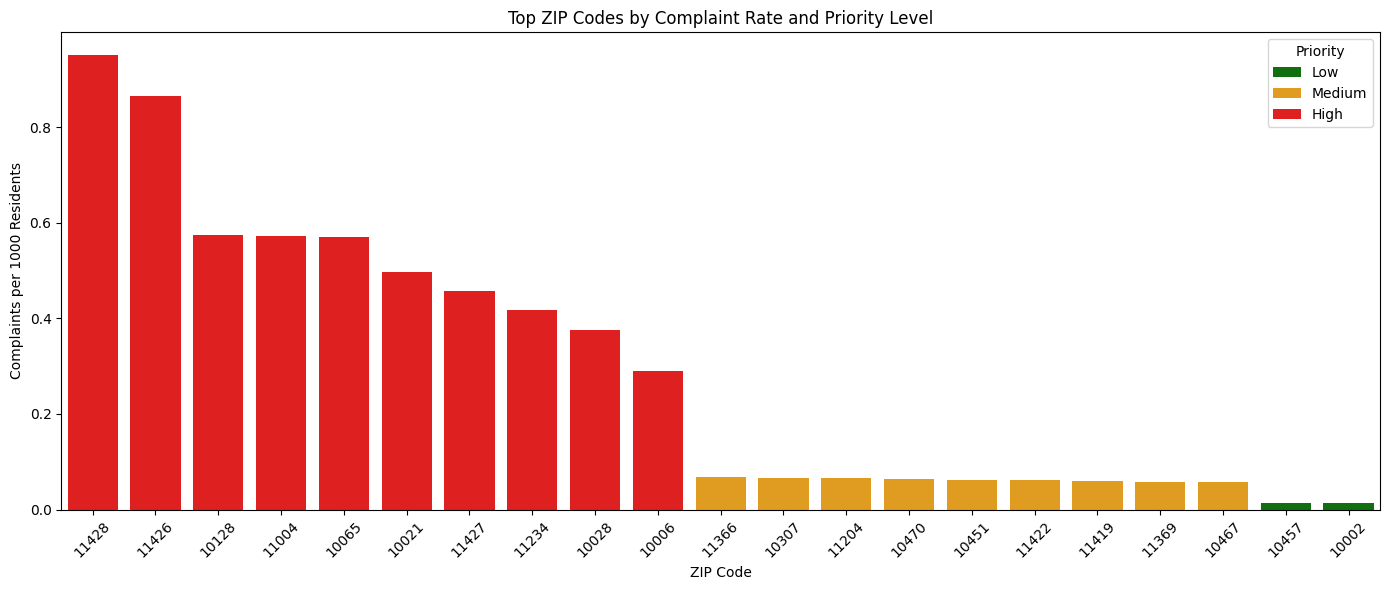

In [95]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data = top_urgency_df,
    x = "zip_code",
    y = "rate_per_1000",
    hue = "priority",
    palette = {"High": "red", "Medium": "orange", "Low": "green"}
)

plt.title("Top ZIP Codes by Complaint Rate and Priority Level")
plt.xlabel("ZIP Code")
plt.ylabel("Complaints per 1000 Residents")
plt.legend(title="Priority")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




<small> To further explore the complaint patterns within each priority level, we create separate bar plots for **High**, **Medium**, and **Low** priority groups. For each group, the plot shows complaint rates per 1,000 residents by ZIP code, with different complaint types distinguished by color using a palette (`Set2`). This detailed breakdown helps identify which specific complaint types are most prevalent in each urgency category and geographic area, supporting targeted intervention strategies. </small>

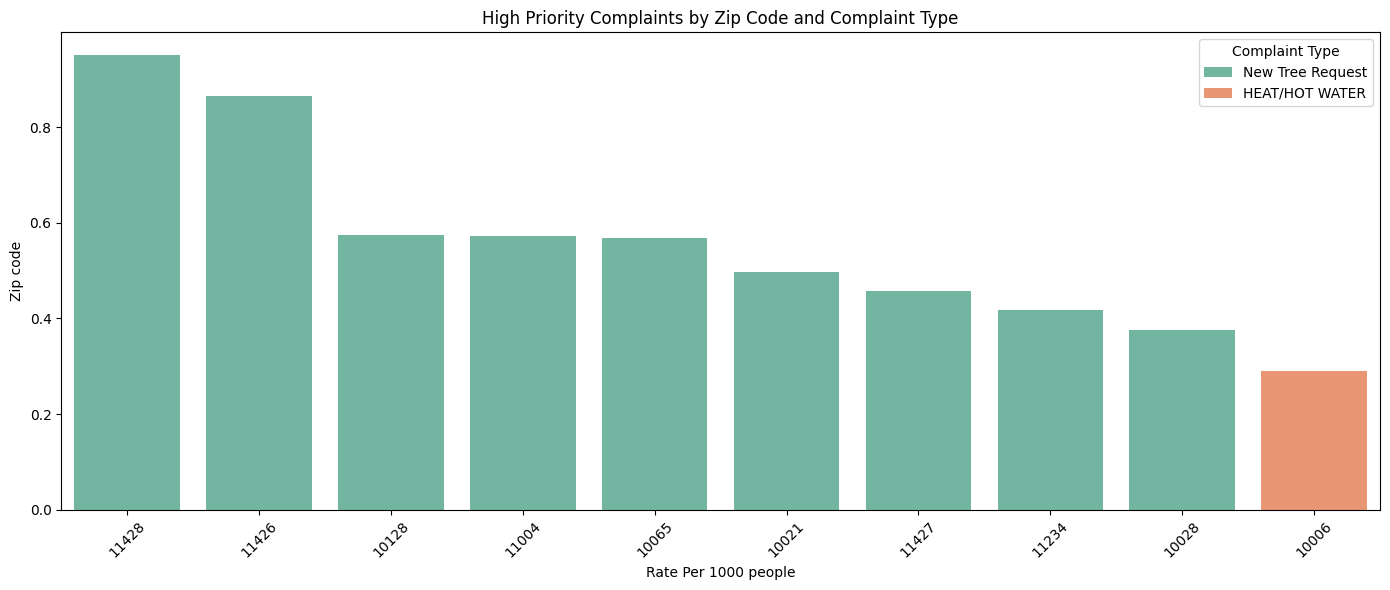

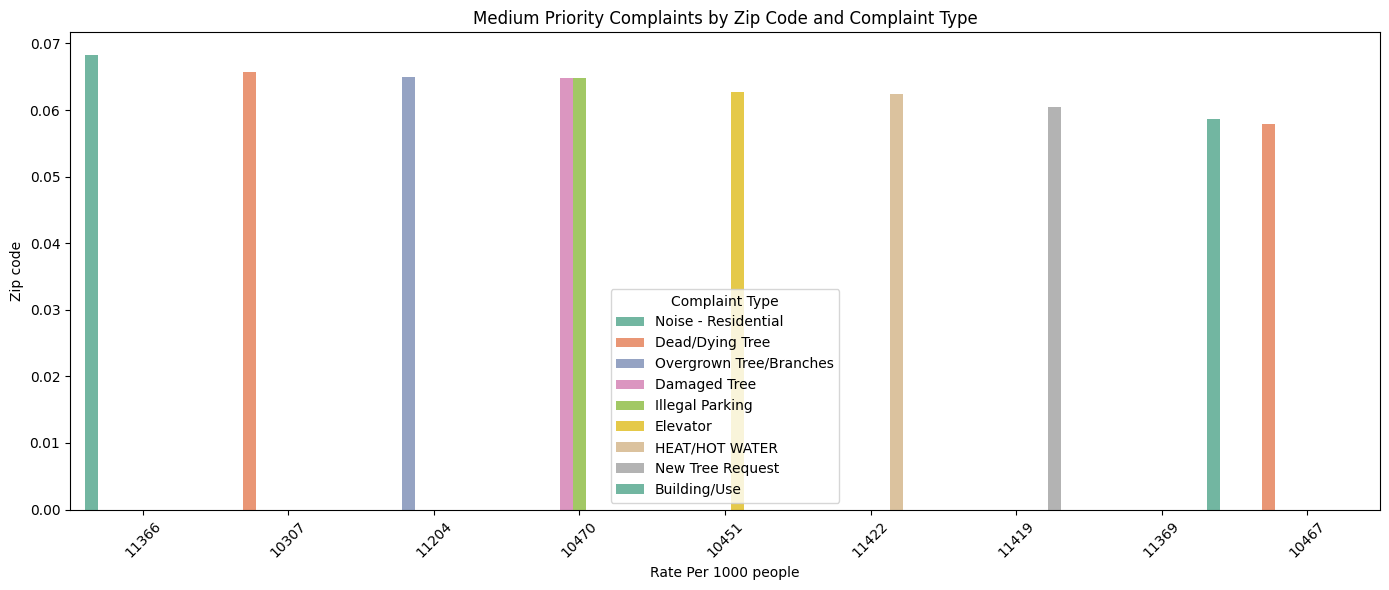

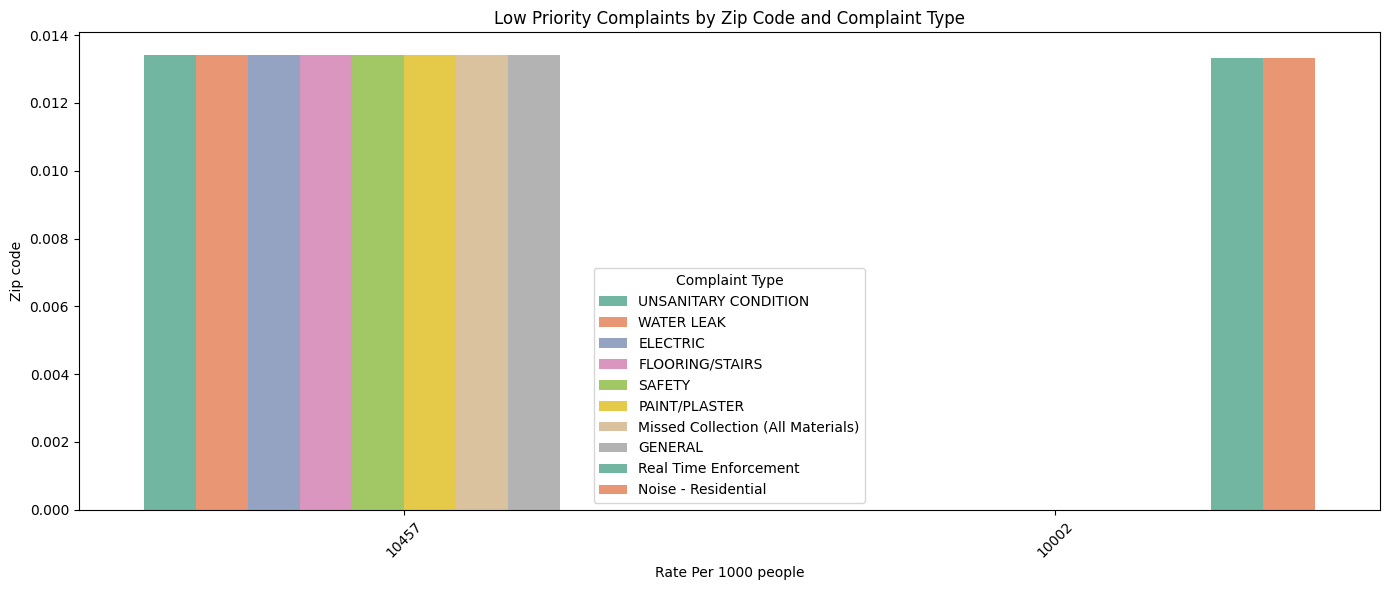

In [96]:
priority_dict = {
    "High": high_sorted,
    "Medium": medium_sorted,
    "Low": low_sorted
}

for priority, key in priority_dict.items():
    plt.figure(figsize=(14, 6))
    sns.barplot(
        data = key,
        x = "zip_code",
        y = "rate_per_1000",
        hue = "complaint_type",
        palette = "Set2"
    )

    plt.title(f"{priority} Priority Complaints by Zip Code and Complaint Type")
    plt.xlabel("Rate Per 1000 people")
    plt.ylabel("Zip code")
    plt.legend(title="Complaint Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<small> In this analysis, we model the distribution of daily complaint counts using the Poisson probability mass function (PMF). First, we count the number of complaints recorded each day. We then calculate the average daily complaint count (`mu`), which serves as the Poisson distribution’s rate parameter. Using this, we compute the theoretical probability of observing different complaint counts (`k`). Finally, we plot the Poisson PMF as a line chart to visualize the expected distribution of daily complaints, helping us understand whether the complaint arrival process follows a Poisson pattern. </small>

In [97]:
# Count complaints per day
daily_counts = merged_df.groupby('created_date').size()

# Compute the average
mu = daily_counts.mean()

# Range of complaint counts (adjust as needed)
k = np.arange(daily_counts.min(), daily_counts.max() + 1)

# Poisson PMF
y = poisson.pmf(k, mu)

fig = go.Figure()
fig.add_trace(go.Scatter(x = k, y = y, mode ='lines', name = f'Mean = {mu:.2f}'))

fig.update_layout(
    title='Poisson PMF: Daily Complaint Counts',
    xaxis_title='K: Number of Complaints in a Day',
    yaxis_title='Probability',
    font=dict(size=16),
    width=700,
    height=400,
    title_x=0.5,
    template="simple_white",
    showlegend=True 
)

fig.show()




<small> In this section, we first, we convert the `created_date` column to datetime format to enable date-based operations. We then extract several time-related features from these dates: the month number (`month`), month name (`mon_of_yr`), day of the month (`day`), and weekday name (`weekday`).
To focus our analysis on the most common issues, we identify the top 10 complaint types by frequency. We filter the dataset to retain only these complaint types, then group and count complaints by month and complaint type (monthly_trends), as well as by weekday, day, and complaint type (weekly_trends).

Additionally, we calculate the total number of complaints per month and per day, regardless of complaint type, to observe overall temporal trends. Finally, we print the earliest and latest complaint dates along with the total number of unique complaint dates to understand the time range and data coverage.
</small>

In [98]:
#Normalize the data under 'created_dates' as actual dates under the pandas DataFrame
merged_df['created_date'] = pd.to_datetime(merged_df['created_date'])

#Create specific DataFrames that contain info abouth the month, month number, and day of complaints made.
merged_df['month'] = merged_df['created_date'].dt.month # 1 to 12
merged_df['mon_of_yr'] = merged_df['created_date'].dt.month_name() #July
merged_df['day'] = merged_df['created_date'].dt.day # 1 to 31
merged_df['weekday'] = merged_df['created_date'].dt.day_name() #Monday, Tuesday, etc

#Group and count complaints by what you hope to find distribution over such as month, week, and day of week
top_10_types = merged_df['complaint_type'].value_counts().nlargest(10).index

#Filter merged_df to keep only top 10 complaint types
filtered_df = merged_df[merged_df['complaint_type'].isin(top_10_types)]

# Group by month and complaint type, then count complaints
# Reshape to have complaint types as columns, filling missing values with 0
monthly_trends = filtered_df.groupby(['mon_of_yr', 'month', 'complaint_type']).size().unstack(fill_value=0)
# Repeat for weekdays instead of months
weekly_trends = filtered_df.groupby(['weekday', 'day', 'complaint_type']).size().unstack(fill_value=0)

#Find total complaints per month and day regardless of type
total_monthly = merged_df.groupby('month').size()
total_daily = merged_df.groupby('day').size()

print(total_monthly)
print(total_daily)

print(merged_df['created_date'].min())
print(merged_df['created_date'].max())
print(merged_df['created_date'].dt.date.nunique())




month
1      60
2      37
3      61
4      82
5     148
6     146
7      57
8     106
9     110
10     68
11     40
12     45
dtype: int64
day
1     51
2     16
3     23
4     32
5     41
6     32
7     28
8     54
9     31
10    25
11    31
12    31
13    29
14    27
15    59
16    36
17    29
18    30
19    47
20    27
21    35
22    22
23    30
24    32
25    18
26    28
27    28
28    23
29    32
30    24
31     9
dtype: int64
2010-08-09 15:20:02
2024-06-11 21:02:25
539


<small> This plot visualizes the seasonal trends of the top complaint types over time by month. Using the `monthly_trends` DataFrame, we create a line chart with markers to show the number of complaints each month for the top ten complaint types. The chart’s title, axis labels, grid, and legend help clearly communicate how complaint volumes fluctuate throughout the year, highlighting any seasonal patterns or spikes. </small>

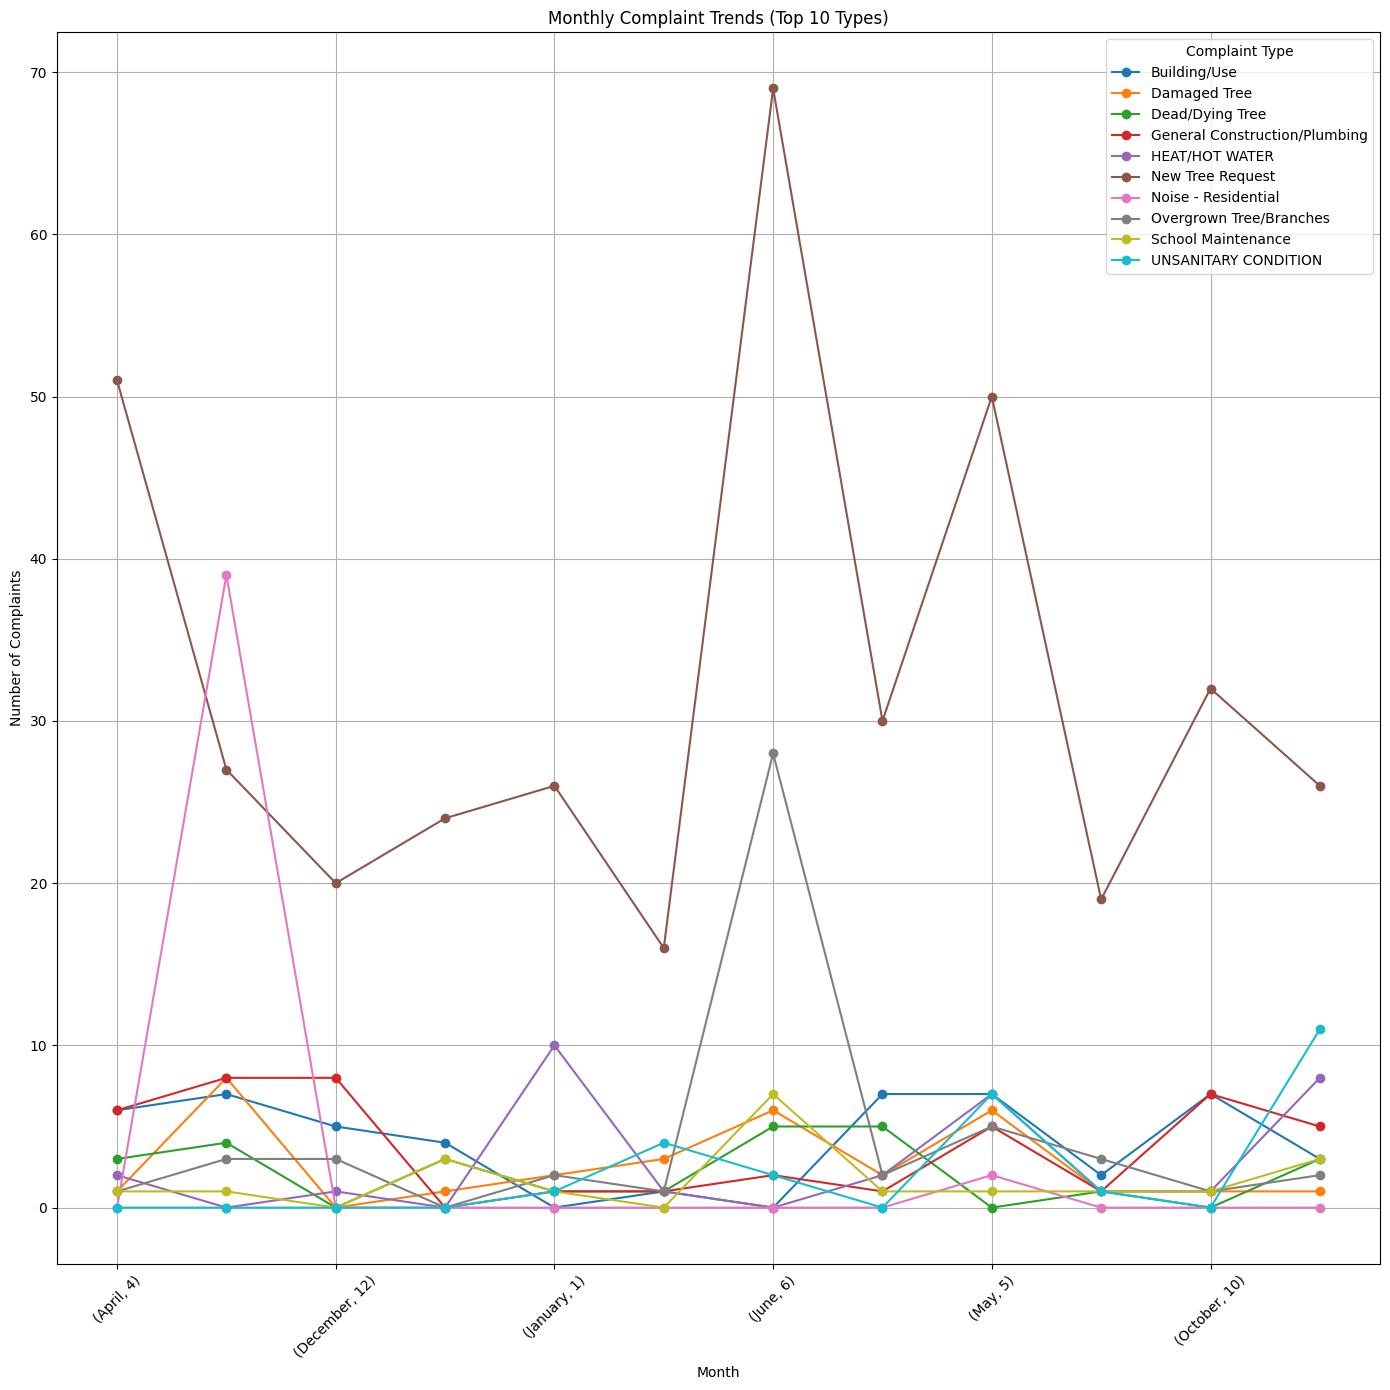

In [99]:
#A. Seasonal Trends (Monthly Over Time)
monthly_trends.plot(figsize=(14, 14), marker = 'o')
plt.title("Monthly Complaint Trends (Top 10 Types)")
plt.ylabel("Number of Complaints")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title="Complaint Type")
plt.show()

<small> This count plot displays the distribution of complaints by day of the week. The days are ordered from Monday to Sunday for intuitive reading. This visualization helps reveal weekly patterns in complaint frequency, showing which days tend to have higher or lower volumes. Understanding these trends can guide resource allocation and response planning throughout the week. </small>

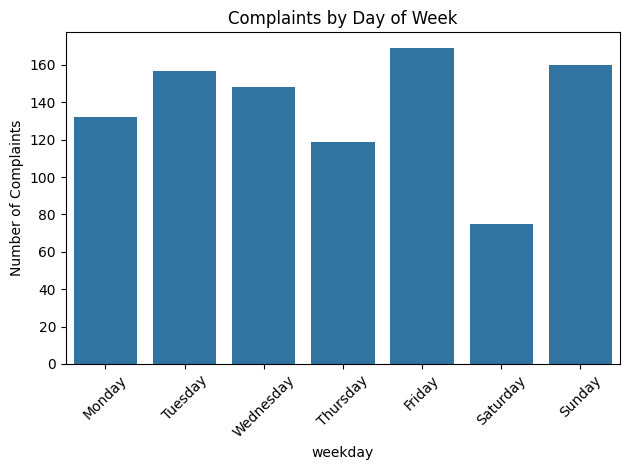

In [100]:
# B. Weekly or Daily Pattern
sns.countplot(
    data=merged_df,
    x='weekday',
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.title("Complaints by Day of Week")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
